In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
torch.backends.cudnn.benchmark = True


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [4]:
BASE_PATH = "../TotalLoL"

TRAIN_LOW = os.path.join(BASE_PATH, "train", "low")
TRAIN_HIGH = os.path.join(BASE_PATH, "train", "high")

RESULTS_PATH = "../results"
ILLUM_MODEL_PATH = os.path.join(RESULTS_PATH, "illumination_net_best_totalLol_training.pth")


In [5]:
class LOLDataset(Dataset):
    def __init__(self, low_dir, high_dir):
        self.low_images = sorted(os.listdir(low_dir))
        self.high_images = sorted(os.listdir(high_dir))
        self.low_dir = low_dir
        self.high_dir = high_dir

    def __len__(self):
        return len(self.low_images)

    def __getitem__(self, idx):
        low = cv2.imread(os.path.join(self.low_dir, self.low_images[idx]))
        high = cv2.imread(os.path.join(self.high_dir, self.high_images[idx]))

        low = cv2.cvtColor(low, cv2.COLOR_BGR2RGB)
        high = cv2.cvtColor(high, cv2.COLOR_BGR2RGB)

        low = torch.from_numpy(low / 255.0).float().permute(2, 0, 1)
        high = torch.from_numpy(high / 255.0).float().permute(2, 0, 1)

        return low, high


In [6]:
dataset = LOLDataset(TRAIN_LOW, TRAIN_HIGH)
loader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)


In [7]:
class IlluminationNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(32, 1, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))


In [8]:
illum_model = IlluminationNet().to(device)
illum_model.load_state_dict(torch.load(ILLUM_MODEL_PATH, map_location=device))
illum_model.eval()

for param in illum_model.parameters():
    param.requires_grad = False

print("Illumination model loaded and frozen.")


Illumination model loaded and frozen.


In [9]:
def correct_illumination(low_img, illum, eps=1e-4):
    return low_img / (illum + eps)


In [10]:
# Basically it is a reusable building block it is being used in the multilscale unet multiple times
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),  # extract features 
            nn.ReLU(), # and it adds non linearity to the model
            nn.Conv2d(out_ch, out_ch, 3, padding=1), # extract features 
            nn.ReLU() # and it adds non linearity to the model
        )

    def forward(self, x):
        return self.block(x)


In [11]:
# It is full Enhancement Network with encoder and decoder and skip connections.....................
class MultiScaleUNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc1 = ConvBlock(3, 64)  
        self.enc2 = ConvBlock(64, 128) 
        self.pool = nn.MaxPool2d(2) # this is max pooling layer it will reduce the spatial dimensions by half so the output will be 128 * 128 * 128 (this will move to bottleneck)

        self.bottleneck = ConvBlock(128, 256) # here the convblock will extract features and the output will be 64 * 64 * 256 (this is the bottleneck layer)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = ConvBlock(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = ConvBlock(128, 64)

        self.final = nn.Conv2d(64, 3, 1)

    def forward(self, x):
        e1 = self.enc1(x) # suppose the image is 256 * 256 * 3 the output will be 256 * 256 * 64
        e2 = self.enc2(self.pool(e1)) # the input will be 256 * 256 * 64 and the output will be 256 * 256 * 128  THIS IS ALSO CALLED DOWNSAMPLING


        b = self.bottleneck(self.pool(e2)) # pooling e2 (128 × 128 × 128 #⬇️ pooling 64 × 64 × 128)
        #Pooling reduced spatial size, and the convolution inside the bottleneck increased the number of channels from 128 to 256.
        
        # UPSAMPLING

        d2 = self.up2(b) # 128 × 128 × 128
        d2 = self.dec2(torch.cat([d2, e2], dim=1)) # Skip connection + channel explosion (on purpose)  #Decoder ConvBlock reduces channels 

        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))  

        return torch.sigmoid(self.final(d1))


In [12]:
l1_loss = nn.L1Loss()

def edge_loss(pred, target):
    pred_gray = torch.mean(pred, dim=1, keepdim=True)
    target_gray = torch.mean(target, dim=1, keepdim=True)
    return torch.mean(torch.abs(pred_gray - target_gray))


In [13]:
refine_model = MultiScaleUNet().to(device)
optimizer = optim.Adam(refine_model.parameters(), lr=1e-4)


In [14]:
# ---- SANITY CHECK: ONE BATCH ----
print("Running one-batch sanity check...")

low_img, high_img = next(iter(loader))
low_img = low_img.to(device)
high_img = high_img.to(device)

with torch.no_grad():
    illum = illum_model(low_img)
    illum_corrected = correct_illumination(low_img, illum)
    out = refine_model(illum_corrected)

print("One batch forward pass successful.")


Running one-batch sanity check...
One batch forward pass successful.


In [15]:
num_epochs = 50

for epoch in range(num_epochs):
    refine_model.train()
    epoch_loss = 0.0

    for low_img, high_img in loader:
        low_img = low_img.to(device)
        high_img = high_img.to(device)

        with torch.no_grad():
            illum = illum_model(low_img)
            illum_corrected = correct_illumination(low_img, illum)

        refined = refine_model(illum_corrected)

        loss = l1_loss(refined, high_img) + 0.1 * edge_loss(refined, high_img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {epoch_loss:.4f}")


Epoch [1/50] | Loss: 0.1586
Epoch [2/50] | Loss: 0.1426
Epoch [3/50] | Loss: 0.1413
Epoch [4/50] | Loss: 0.1389
Epoch [5/50] | Loss: 0.1365
Epoch [6/50] | Loss: 0.1349
Epoch [7/50] | Loss: 0.1324
Epoch [8/50] | Loss: 0.1315
Epoch [9/50] | Loss: 0.1303
Epoch [10/50] | Loss: 0.1300
Epoch [11/50] | Loss: 0.1285
Epoch [12/50] | Loss: 0.1285
Epoch [13/50] | Loss: 0.1269
Epoch [14/50] | Loss: 0.1267
Epoch [15/50] | Loss: 0.1259
Epoch [16/50] | Loss: 0.1255
Epoch [17/50] | Loss: 0.1250
Epoch [18/50] | Loss: 0.1247
Epoch [19/50] | Loss: 0.1249
Epoch [20/50] | Loss: 0.1245
Epoch [21/50] | Loss: 0.1235
Epoch [22/50] | Loss: 0.1233
Epoch [23/50] | Loss: 0.1224
Epoch [24/50] | Loss: 0.1232
Epoch [25/50] | Loss: 0.1221
Epoch [26/50] | Loss: 0.1214
Epoch [27/50] | Loss: 0.1215
Epoch [28/50] | Loss: 0.1210
Epoch [29/50] | Loss: 0.1207
Epoch [30/50] | Loss: 0.1204
Epoch [31/50] | Loss: 0.1195
Epoch [32/50] | Loss: 0.1186
Epoch [33/50] | Loss: 0.1186
Epoch [34/50] | Loss: 0.1184
Epoch [35/50] | Loss: 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.5200834].


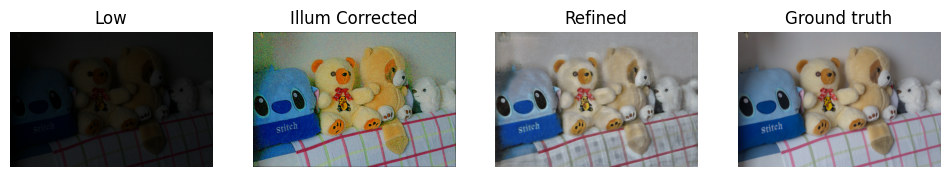

In [18]:
refine_model.eval()

with torch.no_grad():
    low, high = dataset[0]
    low = low.unsqueeze(0).to(device)

    illum = illum_model(low)
    illum_corrected = correct_illumination(low, illum)
    refined = refine_model(illum_corrected)

low = low.squeeze().permute(1,2,0).cpu().numpy()
illum_corrected = illum_corrected.squeeze().permute(1,2,0).cpu().numpy()
refined = refined.squeeze().permute(1,2,0).cpu().numpy()
high = high.permute(1,2,0).numpy()

plt.figure(figsize=(12,4))
plt.subplot(1,4,1); plt.imshow(low); plt.title("Low"); plt.axis("off")
plt.subplot(1,4,2); plt.imshow(illum_corrected); plt.title("Illum Corrected"); plt.axis("off")
plt.subplot(1,4,3); plt.imshow(refined); plt.title("Refined"); plt.axis("off")
plt.subplot(1,4,4); plt.imshow(high); plt.title("Ground truth"); plt.axis("off")
plt.show()


In [17]:
torch.save(refine_model.state_dict(), "../results/reflectance_refine_net_50epoch_TotalLoL.pth")
print("Reflectance refinement model saved.")


Reflectance refinement model saved.
